# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology and Analysis](#methodology)
* [Results and Discussion](#results)
* [Conclusions](#conclusions)
* [References](#references)

## Introduction: Business Problem <a name="introduction"></a>

The current project has as objective to discover the best possible location in Santiago de Chile for **starting a new bar entrepreneurship focused on selling premium craft beers to customers.**

Santiago de Chile has around 7MM people living in an area of 15.400 km2 partitioned in 52 different boroughs. **These boroughs have a population, number of houses, area and a large array of different amenities given.**

Our mission is to **leverage different data science tools that helps to determine which boroughs are the most promising and venues inside these ones to locate the stakeholders’ bar.**

The criteria used for the analysis are:

* **Boroughs with high density of people** would be prefer in order to assure a flow of customers into the bar.
* **Boroughs with low number of people per house** will be prefer due to singles and young couples used to visit more bars than families with kids.
* We will prefer **locations with many restaurants, cinemas, theaters, discos and bars** in order to gain exposure for the targeted customers but **avoiding proximity to bars delivering our same services.**


## Data <a name="data"></a>

In [1]:
#!pip install lxml

import pandas as pd
import numpy as np
import lxml
import re
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sklearn.cluster import KMeans # import k-means from clustering stage
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


For this project we will use 3 main streams of data


In order to solve our problem of best location discovery with need data about the boroughs, specially that one pointing their location, secondly demographics about each borough that allow us to discriminate the boroughs with more potential and thirdly, hot places with complementary and suitable amenities to locate the beer bar that allow us to assurance its future growth and healthy revenues.

### 1.	Data about the boroughs and their location
The data came from a link in Wikipedia that has all the cities and boroughs in Chile and their corresponding latitude and longitude.





In [7]:
url='https://es.wikipedia.org/wiki/Anexo:Comunas_de_Chile'
df=pd.read_html(url, header=0)[0]

We must filter for the boroughs in Santiago, convert the format for the coordinates and drop those columns that are useless for our propose. It is important to notice that each borough has a unique identifier call “CUT” which is useful to cross data later.

In [8]:
def dms2dd(s):
    deg, minutes, seconds, direction =  re.split('[°\'"]', s)
    dd = (float(deg) - float(minutes)/60-float(seconds)/(60*60))
    return dd

In [9]:
df=df[df['Provincia']=='Santiago']
df.drop(['Provincia','Unnamed: 2','Región','IDH 2005','IDH 2005.1', 'Superficie(km2)',"Población2017",'Densidad(hab./km2)' ], axis=1, inplace=True)
df['Latitud']=df['Latitud'].str.replace(",",".")
df['Longitud']=df['Longitud'].str.replace(",",".")
df['Latitude'] = df['Latitud'].apply(dms2dd)
df['Longitude'] = df['Longitud'].apply(dms2dd)
df.drop(['Latitud','Longitud'], axis=1, inplace=True)
df.rename(columns={"CUT (Código Único Territorial)": "CUT", "Nombre": "Borough"}, inplace=True)
df.head()

,CUT,Borough,Latitude,Longitude
294,13101,Santiago,-33.437222,-70.657222
295,13102,Cerrillos,-33.500000,-70.716667
296,13103,Cerro Navia,-33.422000,-70.735000
297,13104,Conchalí,-33.380000,-70.675000
298,13105,El Bosque,-33.567000,-70.675000


Here we can use folium to map all boroughs. We can notice that points are distributed in a circular area

In [10]:
address = 'Santiago, RM'
geolocator = Nominatim(user_agent="cl_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_santiago= folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['Borough']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_santiago)  
    
map_santiago

### 2.	Data about population, number of houses and area of boroughs
In this case the data was extracted from a csv file posted by “Instituto Nacional de Estadisticas” (public institution focused on creating indices and data in Chile).




In [11]:
url= 'https://opendata.arcgis.com/datasets/1c64fcb18f5a41e088b25ef9f42b58d7_0.csv?outSR=%7B%22wkid%22%3A102100%2C%22latestWkid%22%3A3857%7D'
df_population=pd.read_csv(url)

Again, we filter the columns that were useful and the rows with information about the boroughs in Santiago



In [12]:
df_population=df_population[df_population['NOM_PROVIN']=='SANTIAGO']
df_pop=df_population.filter(['COMUNA','T_POB','T_VIV','SUPERFICIE__KM2_','Densidad_'], axis=1)
df_pop.rename(columns={'COMUNA':'CUT',"T_POB": "Population", "T_VIV": "Houses", "SUPERFICIE__KM2_":"Area (km2)",'Densidad_':'Density'}, inplace=True)
df_pop.head()

,CUT,Population,Houses,Area (km2),Density
274,13102,80832,24547,16.779650,4817.263672
275,13131,82900,23855,6.277112,13206.710938
276,13132,85384,31777,28.417034,3004.676758
278,13109,90119,31480,9.979139,9030.739258
283,13113,92787,29801,23.438091,3958.812012


Here we can cross this dataframe with the previous one thanks to the ‘CUT’ code, generating a unique table with information of 32 boroughs

In [13]:
df=df.merge(df_pop, left_on='CUT', right_on='CUT')

In [14]:
df['People/House']=df['Population']/df['Houses']
print(df.shape)
df.head()

(32, 9)


,CUT,Borough,Latitude,Longitude,Population,Houses,Area (km2),Density,People/House
0,13101,Santiago,-33.437222,-70.657222,404495,193628,23.135237,17483.935547,2.089032
1,13102,Cerrillos,-33.500000,-70.716667,80832,24547,16.779650,4817.263672,3.292948
2,13103,Cerro Navia,-33.422000,-70.735000,132622,38020,11.097359,11950.771484,3.488217
3,13104,Conchalí,-33.380000,-70.675000,126955,37759,11.109763,11427.335938,3.362245
4,13105,El Bosque,-33.567000,-70.675000,162505,47941,14.324402,11344.626953,3.389687


#### We are able to extract 3 insights

Around half of the boroughs (15) have low density of people (<8.8k people/km2) and the other half high density (>8.8k people/km2). We must focus on this half.

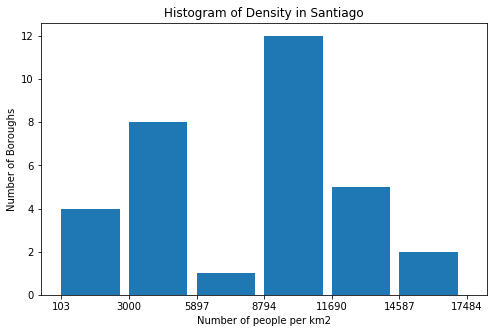

In [15]:
count, bin_edges = np.histogram(df['Density'], 6)

df['Density'].plot(kind='hist', figsize=(8, 5), xticks=bin_edges, bins=6, width=2500)

plt.title('Histogram of Density in Santiago')
plt.ylabel('Number of Boroughs') 
plt.xlabel('Number of people per km2') 
plt.show()

Around one third of the boroughs (10) have a low number of people per houses (<2.85 people/house). We must focus on this third.

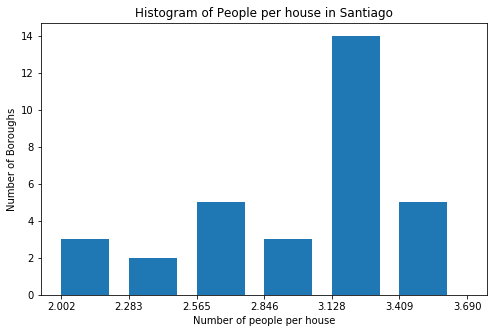

In [16]:
count, bin_edges = np.histogram(df['People/House'], 6)

df['People/House'].plot(kind='hist', figsize=(8, 5), xticks=bin_edges, bins=6, width=.2)

plt.title('Histogram of People per house in Santiago')
plt.ylabel('Number of Boroughs')
plt.xlabel('Number of people per house') 
plt.show()

Finally, with the 2 previous pieces of information we have a quadrant of interest to put focus on

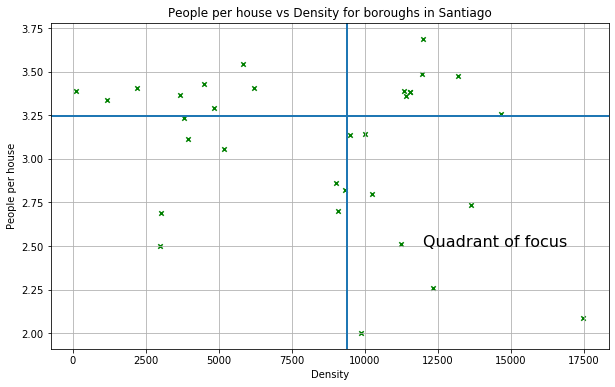

In [17]:
df.plot(kind='scatter', x='Density', y='People/House', figsize=(10, 6),  color='green', marker='x')

plt.title('People per house vs Density for boroughs in Santiago')
plt.xlabel('Density')
plt.ylabel('People per house')
plt.annotate('Quadrant of focus', xy=(12000, 2.5), size=16)
plt.grid(True)
plt.axhline(y=df['People/House'].median(), linewidth=2)
plt.axvline(x=df['Density'].median(), linewidth=2)
plt.show()

### 3.	Data about the venues and their location for each borough
Thanks to the Foursquare API we can extract the location and category for every Venue located in each borough of Santiago.
To extract the info, we use the proper credentials and a range of 2 kilometers around each borough and a limit of 100 venues per borough.

In [20]:
CLIENT_ID = 'LIBU3ZBXSVMVDGM0CPL1BKG2OLRFYZ1HAR3OWDU5RIN4VB30' # your Foursquare ID
CLIENT_SECRET = 'WVMMAU40EHWIECRKOAHZHWH350XL52GHJC2Q2F02DAVO5FO0' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):            
        # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius, 
                LIMIT)

            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']

            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                      'Borough Latitude', 
                      'Borough Longitude', 
                      'Venue', 
                      'Venue Latitude', 
                      'Venue Longitude', 
                      'Venue Category']

    return(nearby_venues)

In [23]:
santiago_venues = getNearbyVenues(names=df['Borough'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

santiago_venues

,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Santiago,-33.437222,-70.657222,Plaza de Bolsillo - Santiago Centro,-33.436778,-70.655481,Plaza
1,Santiago,-33.437222,-70.657222,Starbucks,-33.437938,-70.657007,Coffee Shop
2,Santiago,-33.437222,-70.657222,Amanda's,-33.439206,-70.658247,Arepa Restaurant
3,Santiago,-33.437222,-70.657222,Museo Chileno de Arte Precolombino,-33.438776,-70.652363,Museum
4,Santiago,-33.437222,-70.657222,GYROS BISTRÓ,-33.439793,-70.655792,Sandwich Place
...,...,...,...,...,...,...,...
1883,Vitacura,-33.400000,-70.600000,Eric Kayser,-33.416495,-70.597481,Deli / Bodega
1884,Vitacura,-33.400000,-70.600000,Check INN,-33.388067,-70.615203,Restaurant
1885,Vitacura,-33.400000,-70.600000,Brooks Night,-33.389916,-70.615861,Athletics & Sports
1886,Vitacura,-33.400000,-70.600000,Ultra Music Festival - Chile 2015,-33.391467,-70.617569,Concert Hall


 Due to the big range we must look for possible duplicates in the dataframe

In [24]:
santiago_venues.drop_duplicates(subset =['Venue','Venue Latitude', 'Venue Longitude'], inplace=True)
print(santiago_venues.shape)

(1630, 7)


Finally, we can notice that there are a huge variance in the number of venues per borough

In [25]:
santiago_venues.groupby(['Borough']).count()

,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Borough,,,,,,
Cerrillos,56,56,56,56,56,56
Cerro Navia,19,19,19,19,19,19
Conchalí,52,52,52,52,52,52
El Bosque,26,26,26,26,26,26
Estación Central,59,59,59,59,59,59
Huechuraba,24,24,24,24,24,24
Independencia,73,73,73,73,73,73
La Cisterna,74,74,74,74,74,74
La Florida,24,24,24,24,24,24


## Methodology and Analysis<a name="methodology"></a>

The methodology we are going to follow has 3 stages:

**1. Clustering the boroughs with k-means**

Here we want to identify the type of boroughs we are dealing with so we can discard those useless for the purpose of this project

**2. Slicing the clusters of boroughs according to density and people per house indexes**

Here we want to select the subset of boroughs that meet the demographic requirements stated at the introduction, locations with high density of people and few people per house (singles, couples without children, etc.)

**3. Select neighborhoods within these boroughs with a density of "complementary" amenities**

Finally, from this small portion of borough we would identify those that contain neighborhoods packed with complementary amenities for starting a craft beer bar (i.e. restaurants, cinemas, theaters, other types of bars, etc.)


### 1. Clustering the boroughs with k-means


First, we need to create a dummy variable for each venue category in our table and calculate and average for every Borough in order to get a weighted collection of categories per Borough

In [26]:
santiago_onehot = pd.get_dummies(santiago_venues[['Venue Category']], prefix="", prefix_sep="")

santiago_onehot['Borough'] = santiago_venues['Borough'] 

fixed_columns = [santiago_onehot.columns[-1]] + list(santiago_onehot.columns[:-1])

santiago_onehot = santiago_onehot[fixed_columns]

santiago_grouped = santiago_onehot.groupby('Borough').mean().reset_index()

santiago_grouped.head()

,Borough,Airport,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Video Game Store,Video Store,Volleyball Court,Water Park,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,Cerrillos,0.017857,0.017857,0.0,0.0,0.0,0.000000,0.017857,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Cerro Navia,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Conchalí,0.000000,0.019231,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,El Bosque,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.038462,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Estación Central,0.000000,0.000000,0.0,0.0,0.0,0.016949,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Then we can sort this weighted collection to get the top 10 categories for each borough

In [27]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [28]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

borough_venues_sorted = pd.DataFrame(columns=columns)
borough_venues_sorted['Borough'] = santiago_grouped['Borough']

for ind in np.arange(santiago_grouped.shape[0]):
    borough_venues_sorted.iloc[ind, 1:] = return_most_common_venues(santiago_grouped.iloc[ind, :], num_top_venues)

borough_venues_sorted.head()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Cerrillos,Fast Food Restaurant,Ice Cream Shop,Sandwich Place,Pharmacy,Burger Joint,Movie Theater,Food & Drink Shop,Park,Café,Department Store
1,Cerro Navia,Bus Station,Park,Japanese Restaurant,Pharmacy,Burger Joint,Fried Chicken Joint,Flea Market,Mountain,Grocery Store,Chinese Restaurant
2,Conchalí,Furniture / Home Store,Department Store,Ice Cream Shop,Pharmacy,Restaurant,Farmers Market,Gym,Bakery,Sushi Restaurant,Donut Shop
3,El Bosque,Flea Market,Pharmacy,Pizza Place,Burger Joint,Supermarket,Gastropub,Sushi Restaurant,Mobile Phone Shop,Chinese Restaurant,Bar
4,Estación Central,Pharmacy,Bakery,Fast Food Restaurant,Snack Place,Hot Dog Joint,Chinese Restaurant,Museum,Asian Restaurant,Bar,Sushi Restaurant


Finally, we applied the machine learning clustering technique called K means for the boroughs and with a k parameter of 5. It's done with the objective to discriminate which boroughs we should choose without doing calculations borough by borough

In [29]:
kclusters = 5

santiago_grouped_clustering = santiago_grouped.drop('Borough', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(santiago_grouped_clustering)

kmeans.labels_[0:10]

borough_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

borough_venues_sorted.head()

,Cluster Labels,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Cerrillos,Fast Food Restaurant,Ice Cream Shop,Sandwich Place,Pharmacy,Burger Joint,Movie Theater,Food & Drink Shop,Park,Café,Department Store
1,0,Cerro Navia,Bus Station,Park,Japanese Restaurant,Pharmacy,Burger Joint,Fried Chicken Joint,Flea Market,Mountain,Grocery Store,Chinese Restaurant
2,0,Conchalí,Furniture / Home Store,Department Store,Ice Cream Shop,Pharmacy,Restaurant,Farmers Market,Gym,Bakery,Sushi Restaurant,Donut Shop
3,0,El Bosque,Flea Market,Pharmacy,Pizza Place,Burger Joint,Supermarket,Gastropub,Sushi Restaurant,Mobile Phone Shop,Chinese Restaurant,Bar
4,2,Estación Central,Pharmacy,Bakery,Fast Food Restaurant,Snack Place,Hot Dog Joint,Chinese Restaurant,Museum,Asian Restaurant,Bar,Sushi Restaurant


And we merged our the data

In [31]:
santiago_merged = df

santiago_merged = santiago_merged.join(borough_venues_sorted.set_index('Borough'), on='Borough')

santiago_merged.head()

,CUT,Borough,Latitude,Longitude,Population,Houses,Area (km2),Density,People/House,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,13101,Santiago,-33.437222,-70.657222,404495,193628,23.135237,17483.935547,2.089032,0,Coffee Shop,Art Museum,Tea Room,Bookstore,Sandwich Place,Café,Pizza Place,Theater,Bar,Hotel
1,13102,Cerrillos,-33.500000,-70.716667,80832,24547,16.779650,4817.263672,3.292948,0,Fast Food Restaurant,Ice Cream Shop,Sandwich Place,Pharmacy,Burger Joint,Movie Theater,Food & Drink Shop,Park,Café,Department Store
2,13103,Cerro Navia,-33.422000,-70.735000,132622,38020,11.097359,11950.771484,3.488217,0,Bus Station,Park,Japanese Restaurant,Pharmacy,Burger Joint,Fried Chicken Joint,Flea Market,Mountain,Grocery Store,Chinese Restaurant
3,13104,Conchalí,-33.380000,-70.675000,126955,37759,11.109763,11427.335938,3.362245,0,Furniture / Home Store,Department Store,Ice Cream Shop,Pharmacy,Restaurant,Farmers Market,Gym,Bakery,Sushi Restaurant,Donut Shop
4,13105,El Bosque,-33.567000,-70.675000,162505,47941,14.324402,11344.626953,3.389687,0,Flea Market,Pharmacy,Pizza Place,Burger Joint,Supermarket,Gastropub,Sushi Restaurant,Mobile Phone Shop,Chinese Restaurant,Bar


It is possible to notice that the k-means model creates the cluster 0 and 2 with a group of boroughs while the clusters 1, 3 and 4 only have 1 or 2 boroughs. We will consider these last clusters as outliers for our analysis

In [32]:
santiago_merged.groupby(['Cluster Labels']).count()

,CUT,Borough,Latitude,Longitude,Population,Houses,Area (km2),Density,People/House,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,,,,,,,
0,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14
3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


And it possible to create a map to visualize the results

In [33]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(santiago_merged['Latitude'], santiago_merged['Longitude'], santiago_merged['Borough'], santiago_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[-1+cluster],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


### 2. Slicing the clusters of boroughs according to density and people per house indexes

Here we are going to work with the cluster 0 and 2. Using the medians of 'Density' and 'People per house' we can slice these clusters in order to discard those boroughs with less potential up front.

The cluster 0 satisfy the fact of having 'complementary amenities' for our beer bar (i.e. restaurants, parks, hotels, nightclubs, etc.)

In [36]:
cluster0=santiago_merged.loc[santiago_merged['Cluster Labels'] == 0,:]
                             
cluster0

,CUT,Borough,Latitude,Longitude,Population,Houses,Area (km2),Density,People/House,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,13101,Santiago,-33.437222,-70.657222,404495,193628,23.135237,17483.935547,2.089032,0,Coffee Shop,Art Museum,Tea Room,Bookstore,Sandwich Place,Café,Pizza Place,Theater,Bar,Hotel
1,13102,Cerrillos,-33.500000,-70.716667,80832,24547,16.779650,4817.263672,3.292948,0,Fast Food Restaurant,Ice Cream Shop,Sandwich Place,Pharmacy,Burger Joint,Movie Theater,Food & Drink Shop,Park,Café,Department Store
2,13103,Cerro Navia,-33.422000,-70.735000,132622,38020,11.097359,11950.771484,3.488217,0,Bus Station,Park,Japanese Restaurant,Pharmacy,Burger Joint,Fried Chicken Joint,Flea Market,Mountain,Grocery Store,Chinese Restaurant
3,13104,Conchalí,-33.380000,-70.675000,126955,37759,11.109763,11427.335938,3.362245,0,Furniture / Home Store,Department Store,Ice Cream Shop,Pharmacy,Restaurant,Farmers Market,Gym,Bakery,Sushi Restaurant,Donut Shop
4,13105,El Bosque,-33.567000,-70.675000,162505,47941,14.324402,11344.626953,3.389687,0,Flea Market,Pharmacy,Pizza Place,Burger Joint,Supermarket,Gastropub,Sushi Restaurant,Mobile Phone Shop,Chinese Restaurant,Bar
10,13111,La Granja,-33.533333,-70.625000,116571,34423,10.089199,11554.039062,3.386428,0,Bakery,Park,Salad Place,Soccer Field,Bus Line,Moving Target,Shopping Mall,Big Box Store,Science Museum,Basketball Court
13,13114,Las Condes,-33.416667,-70.583333,294838,118007,99.041100,2976.925781,2.498479,0,Hotel,Plaza,Coffee Shop,Bakery,Ice Cream Shop,Park,Cosmetics Shop,Peruvian Restaurant,Gym / Fitness Center,Italian Restaurant
14,13115,Lo Barnechea,-33.350000,-70.516667,105833,31225,1023.193542,103.433998,3.389367,0,Gym,Restaurant,Shopping Mall,Auto Garage,Burger Joint,Sushi Restaurant,Bakery,Golf Course,Sandwich Place,Italian Restaurant
19,13120,Ñuñoa,-33.454000,-70.604000,208237,92248,16.856802,12353.292969,2.257361,0,Coffee Shop,Peruvian Restaurant,Pizza Place,Café,Bakery,Italian Restaurant,Sandwich Place,Plaza,Gym,Yoga Studio
20,13121,Pedro Aguirre Cerda,-33.466333,-70.633667,101174,29906,8.755928,11554.915039,3.383067,0,Sandwich Place,Restaurant,South American Restaurant,Asian Restaurant,Burger Joint,Mexican Restaurant,Flea Market,Bakery,Latin American Restaurant,BBQ Joint


Applying the median slicing we get a subset of 4 boroughs, with a 'Density' mean of 12.427 and 'People per house' mean of 2.37

In [138]:
cluster0_filter=cluster0[(cluster0['Density']>df['Density'].median()) & (cluster0['People/House']<df['People/House'].median())]
print(cluster0_filter['Density'].mean(), cluster0_filter['People/House'].mean())
cluster0_filter.reset_index(inplace=True)
cluster0_filter.head()


12427.0280761725 2.3735781606150073


,index,CUT,Borough,Latitude,Longitude,Population,Houses,Area (km2),Density,People/House,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,13101,Santiago,-33.437222,-70.657222,404495,193628,23.135237,17483.935547,2.089032,...,Coffee Shop,Art Museum,Tea Room,Bookstore,Sandwich Place,Café,Pizza Place,Theater,Bar,Hotel
1,19,13120,Ñuñoa,-33.454000,-70.604000,208237,92248,16.856802,12353.292969,2.257361,...,Coffee Shop,Peruvian Restaurant,Pizza Place,Café,Bakery,Italian Restaurant,Sandwich Place,Plaza,Gym,Yoga Studio
2,22,13123,Providencia,-33.435000,-70.616000,142079,70965,14.394146,9870.609375,2.002100,...,French Restaurant,Park,Pizza Place,Hotel,Ice Cream Shop,Restaurant,Bookstore,Bakery,Dance Studio,Coffee Shop
3,26,13127,Recoleta,-33.406000,-70.640000,157851,50178,15.784667,10000.274414,3.145821,...,Park,Nightclub,Pharmacy,Bakery,Pizza Place,Other Great Outdoors,Sushi Restaurant,Gym / Fitness Center,Restaurant,Café


The cluster 2 satisfy the fact of having 'complementary amenities' too (i.e. restaurants, parks, food trucks, etc.)

In [41]:
cluster2=santiago_merged.loc[santiago_merged['Cluster Labels'] == 2, santiago_merged.columns[[1] + list(range(5, santiago_merged.shape[1]))]]
cluster2

,Borough,Houses,Area (km2),Density,People/House,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Estación Central,52486,14.353261,10244.431641,2.801528,2,Pharmacy,Bakery,Fast Food Restaurant,Snack Place,Hot Dog Joint,Chinese Restaurant,Museum,Asian Restaurant,Bar,Sushi Restaurant
6,Huechuraba,28945,44.898300,2197.655518,3.408913,2,Metro Station,Convenience Store,Bakery,Golf Course,Plaza,Outdoors & Recreation,Snack Place,Cafeteria,Shop & Service,Café
7,Independencia,36666,7.355460,13633.545898,2.734986,2,Restaurant,Sandwich Place,Park,Peruvian Restaurant,Chinese Restaurant,Farmers Market,Café,BBQ Joint,Plaza,Fast Food Restaurant
8,La Cisterna,31480,9.979139,9030.739258,2.862738,2,Chinese Restaurant,Sushi Restaurant,Pizza Place,Pharmacy,Seafood Restaurant,Bakery,Burger Joint,Sandwich Place,Park,Bar
12,La Reina,29801,23.438091,3958.812012,3.113553,2,Soccer Field,Chinese Restaurant,Restaurant,Park,Pizza Place,Nail Salon,Bakery,Racetrack,Plaza,Sushi Restaurant
16,Lo Prado,29526,6.560049,14671.995117,3.259805,2,Sushi Restaurant,Soccer Field,Bus Station,Nightclub,Pharmacy,Bakery,Soccer Stadium,Chinese Restaurant,Fried Chicken Joint,Asian Restaurant
17,Macul,43121,12.842276,9074.249023,2.702488,2,Chinese Restaurant,Restaurant,Bakery,Soccer Field,Sandwich Place,Pizza Place,Peruvian Restaurant,Sushi Restaurant,BBQ Joint,Bus Station
18,Maipú,161354,137.676132,3788.797607,3.232811,2,Chinese Restaurant,Sushi Restaurant,Bar,Pharmacy,Pizza Place,Sandwich Place,Park,Plaza,Asian Restaurant,Seafood Restaurant
23,Pudahuel,68940,197.258331,1167.469116,3.340484,2,Food Truck,Liquor Store,Fast Food Restaurant,BBQ Joint,Chinese Restaurant,Pharmacy,Soccer Stadium,Steakhouse,Furniture / Home Store,Bus Station
24,Quilicura,62470,57.321335,3670.710205,3.368177,2,Pharmacy,Park,Chinese Restaurant,Food Truck,Bus Line,Flea Market,Bar,Bakery,Fast Food Restaurant,Restaurant


Applying the median slicing in the cluster we get a subset of 4 boroughs as well, but a lower 'Density' mean of 11.152 and a higher 'People per house' mean of 2.79

In [51]:
cluster2_filter=cluster2[(cluster2['Density']>df['Density'].median()) & (cluster2['People/House']<df['People/House'].median())]
print(cluster2_filter['Density'].mean(), cluster2_filter['People/House'].mean())
cluster2_filter.reset_index(inplace=True)
cluster2_filter.head()


11152.96850586 2.7974642053456296


,index,Borough,Houses,Area (km2),Density,People/House,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,5,Estación Central,52486,14.353261,10244.431641,2.801528,2,Pharmacy,Bakery,Fast Food Restaurant,Snack Place,Hot Dog Joint,Chinese Restaurant,Museum,Asian Restaurant,Bar,Sushi Restaurant
1,7,Independencia,36666,7.355460,13633.545898,2.734986,2,Restaurant,Sandwich Place,Park,Peruvian Restaurant,Chinese Restaurant,Farmers Market,Café,BBQ Joint,Plaza,Fast Food Restaurant
2,28,San Joaquín,30096,9.942262,9504.075195,3.139686,2,Food Truck,Restaurant,Theater,Farmers Market,Sandwich Place,Chinese Restaurant,BBQ Joint,Sushi Restaurant,Gastropub,Electronics Store
3,29,San Miguel,42947,9.613154,11229.821289,2.513656,2,Sushi Restaurant,Pizza Place,Restaurant,Plaza,Peruvian Restaurant,Park,Latin American Restaurant,Pharmacy,Bakery,Seafood Restaurant


So, we decided to continue working with the cluster 0 filtered and its 4 boroughs

### 3. Select neighborhoods within these boroughs with a density of "complementary" amenities

Here we are going to look up for the neighborhoods with more potential for locating a premium craft beer bar within each borough, in particular those neighborhoods packed with bars.

First we create a function to extract all the bars at the within each borough.

In [48]:
from pandas.io.json import json_normalize
def get_category_type(row):
        try:
            categories_list = row['categories']
        except:
            categories_list = row['venue.categories']

        if len(categories_list) == 0:
            return None
        else:
            return categories_list[0]['name']

def getNearbyBars( latitude, longitude, radius=1000, LIMIT=50,search_query='Bar'):      
# create the API request URL
    url = url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        latitude, 
        longitude, 
        VERSION, 
        search_query, 
        radius, 
        LIMIT)


    # make the GET request
    
    results = requests.get(url).json()
    venues=results['response']['venues']
    dataframe = json_normalize(venues)

    filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
    dataframe_filtered = dataframe.loc[:, filtered_columns]

    # filter the category for each row
    dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

    # clean column names by keeping only last term
    dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
            

    return(dataframe_filtered)

Here we extract all the bars within the **Santiago Borough**

In [139]:
santiago_bars=[]
i=0
santiago_bars.append(getNearbyBars(latitude=cluster0_filter.loc[i,'Latitude'],longitude=cluster0_filter.loc[i,'Longitude']))
santiago_bars[i].drop(['address','labeledLatLngs','city','state','country', 'formattedAddress',"crossStreet",'postalCode' ], axis=1, inplace=True)
santiago_bars[i].head()

,name,categories,lat,lng,distance,cc,id
0,Bar Nacional 1,South American Restaurant,-33.439843,-70.653029,486,CL,4b686332f964a52065752be3
1,Bar Nacional 2,Bar,-33.439575,-70.652301,526,CL,4b587fc9f964a520b55a28e3
2,Bar Nacional 3,Restaurant,-33.442458,-70.649687,910,CL,4b685244f964a5208d712be3
3,Bar La Unión Chica,Bar,-33.443312,-70.651074,886,CL,4dc00a7c43a147cd6eceeadd
4,bar devic,Beer Garden,-33.441018,-70.665086,843,CL,505e7aa3e4b0a70768115621


And map them, coloring in yellow those bars specialized in selling beers. There are plenty of bars in the nearby but only 2 of them specialized in beers so this is a potential neighborhood

In [98]:
map0 = folium.Map(
    location=[cluster0_filter.loc[i,'Latitude'],cluster0_filter.loc[i,'Longitude']]
    , zoom_start=13)

folium.features.CircleMarker(
    [cluster0_filter.loc[i,'Latitude'],cluster0_filter.loc[i,'Longitude']],
    radius=10,
    color='red',
    popup=cluster0_filter.loc[i,'Borough'],
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(map0)

for lat, lng, label in zip(santiago_bars[i].lat, santiago_bars[i].lng, santiago_bars[i].categories):
   
    if 'Beer' in str(label):
        colour='yellow'
    else:
        colour='blue'
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color=colour,
        popup=label,
        fill = True,
        fill_color=colour,
        fill_opacity=0.6
    ).add_to(map0)

# display map
map0

Here we extract all the bars within the **Ñuñoa Borough**

In [141]:
i=1
santiago_bars.append(getNearbyBars(latitude=cluster0_filter.loc[i,'Latitude'],longitude=cluster0_filter.loc[i,'Longitude']))
#santiago_bars[i].drop(['formattedAddress',"crossStreet",'postalCode' ], axis=1, inplace=True)
santiago_bars[i].head()

,name,categories,address,lat,lng,labeledLatLngs,distance,cc,city,state,country,formattedAddress,crossStreet,postalCode,id
0,Bar C-ñal,Concert Hall,Irarrazabal 2191,-33.454075,-70.608077,"[{'label': 'display', 'lat': -33.454075, 'lng'...",378,CL,Santiago,Santiago Metropolita,Chile,"[Irarrazabal 2191, Santiago, Santiago Metropol...",NaN,NaN,4bd8d9822e6f0f47c8eb0808
1,Bar Sin Nombre,Bar,Av. Irarrázaval 3420,-33.455060,-70.595159,"[{'label': 'display', 'lat': -33.45506039, 'ln...",829,CL,Santiago de Chile,Metropolitana de Santiago de Chile,Chile,"[Av. Irarrázaval 3420 (Holanda), Santiago de C...",Holanda,NaN,4c05d72991d776b07413f8f9
2,Mephisto Bar,Bar,José Pedro Alessandri 103,-33.455956,-70.597991,"[{'label': 'display', 'lat': -33.4559564584904...",599,CL,Ñuñoa,Metropolitana de Santiago de Chile,Chile,"[José Pedro Alessandri 103, Ñuñoa, Metropolita...",NaN,NaN,4b7f187bf964a520231630e3
3,Bar The Clinic,Bar,Jorge Washington 58,-33.454466,-70.594196,"[{'label': 'display', 'lat': -33.454466, 'lng'...",912,CL,Ñuñoa,Metropolitana de Santiago de Chile,Chile,"[Jorge Washington 58 (Plaza Ñuñoa), 7790827 Ñu...",Plaza Ñuñoa,7790827,5103e50ce4b0f0740f23e239
4,Mizu Sushi Bar & Delivery,Japanese Restaurant,NaN,-33.455685,-70.605759,"[{'label': 'display', 'lat': -33.4556847549477...",248,CL,Santiago de Chile,Metropolitana de Santiago de Chile,Chile,"[Santiago de Chile, Metropolitana de Santiago ...",NaN,NaN,5115a484e4b034e6cf9c8ece


And map them, coloring in yellow those bars specialized in selling beers. Again there are plenty of bars in the nearby but only 2 of them specialized in beers, which are far apart each other, so this is a potential neighborhood

In [137]:
i=1
map1 = folium.Map(
    location=[cluster0_filter.loc[i,'Latitude'],cluster0_filter.loc[i,'Longitude']]
    , zoom_start=15)

folium.features.CircleMarker(
    [cluster0_filter.loc[i,'Latitude'],cluster0_filter.loc[i,'Longitude']],
    radius=10,
    color='red',
    popup=cluster0_filter.loc[i,'Borough'],
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(map1)

for lat, lng, label in zip(santiago_bars[i].lat, santiago_bars[i].lng, santiago_bars[i].categories):
   
    if 'Beer' in str(label):
        colour='yellow'
    else:
        colour='blue'
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color=colour,
        fill = True,
        fill_color=colour,
        fill_opacity=0.6
    ).add_to(map1)


# display map
map1

Here we extract all the bars within the **Providencia Borough**

In [143]:
i=2
santiago_bars.append(getNearbyBars(latitude=cluster0_filter.loc[i,'Latitude'],longitude=cluster0_filter.loc[i,'Longitude']))
santiago_bars[i].drop(['address','labeledLatLngs','city','state','country', 'formattedAddress',"crossStreet",'postalCode' ], axis=1, inplace=True)
santiago_bars[2].head()

,name,categories,lat,lng,distance,cc,neighborhood,id
0,Patxaran Bar,Bar,-33.436440,-70.616253,162,CL,NaN,4e5286aac65ba127fb330cf0
1,Domani Pizzeria Bar,Pizza Place,-33.431115,-70.618464,489,CL,Providencia,5896af397ff1e43860cd3ede
2,Bar Nativo,Bar,-33.431058,-70.618685,504,CL,NaN,4ed05a866c2510ace0ec7195
3,Pacto Arte Bar,Bar,-33.431200,-70.618630,488,CL,NaN,4ceefc887b94370430513053
4,Bar Sísmico,Karaoke Bar,-33.442676,-70.614595,864,CL,NaN,4c099e78bbc676b0ad9248d5


And map them, coloring in yellow those bars specialized in selling beers. Again there are plenty of bars in the nearby but only 1 of them specialized in beers and far from the high density of bars, so this is another potential neighborhood

In [125]:
i=2
map2 = folium.Map(
    location=[cluster0_filter.loc[i,'Latitude'],cluster0_filter.loc[i,'Longitude']]
    , zoom_start=15)

folium.features.CircleMarker(
   [cluster0_filter.loc[i,'Latitude'],cluster0_filter.loc[i,'Longitude']],
    radius=10,
    color='red',
    popup=cluster0_filter.loc[i,'Borough'],
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(map2)

for lat, lng, label in zip(santiago_bars[i].lat, santiago_bars[i].lng, santiago_bars[i].categories):
   
    if 'Beer' in str(label):
        colour='yellow'
    else:
        colour='blue'
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color=colour,
        popup=label,
        fill = True,
        fill_color=colour,
        fill_opacity=0.6
    ).add_to(map2)

# display map
map2

Here we extract all the bars within the **Recoleta Borough**

In [144]:
i=3
santiago_bars.append(getNearbyBars(latitude=cluster0_filter.loc[i,'Latitude'],longitude=cluster0_filter.loc[i,'Longitude']))
santiago_bars[i].drop(['address','labeledLatLngs','country', 'formattedAddress' ], axis=1, inplace=True)
santiago_bars[3].head()

,name,categories,lat,lng,distance,cc,id
0,Royal Salute ~bar~,Bar,-33.403015,-70.632568,766,CL,55720d30498ebb629de95970
1,Barrio Einstein,Housing Development,-33.405891,-70.646516,605,CL,544bc3c7498eefae2e4f5b8e
2,Barraca de Fierro,Hardware Store,-33.399540,-70.643070,773,CL,4fbe38d1e4b0bb10a26f0fe6
3,Barrio los olivos,Church,-33.411895,-70.638116,679,CL,4ff061b1e4b0616aaaba94f4
4,Barrio El Salto Chico,Road,-33.415812,-70.642098,1109,CL,4fa121bee4b0f30726e0e1bd


In this case we map the bars but there are only 4 of them far apart each other, we consider it is not a neighborhood with potential for our beer bar

In [130]:
i=3
map3 = folium.Map(
    location=[cluster0_filter.loc[i,'Latitude'],cluster0_filter.loc[i,'Longitude']]
    , zoom_start=15)

folium.features.CircleMarker(
    [cluster0_filter.loc[i,'Latitude'],cluster0_filter.loc[i,'Longitude']],
    radius=10,
    color='red',
    popup=cluster0_filter.loc[i,'Borough'],
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(map3)

for lat, lng, label in zip(santiago_bars[i].lat, santiago_bars[i].lng, santiago_bars[i].categories):
   
    if 'Beer' in str(label):
        colour='yellow'
    else:
        colour='blue'
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color=colour,
        popup=label,
        fill = True,
        fill_color=colour,
        fill_opacity=0.6
    ).add_to(map3)

# display map
map3

## Results and Discussion <a name="results"></a>

As a result, for our project we got that there 3 boroughs with neighborhoods within them capable of sustain and assurance a new premium craft beer. These are Santiago, Ñuñoa and Provindencia. It is because there are plenty of ‘complementary' amenities in a range of 1km around the 'heart' of each borough which are helpful to gain exposure for target customers, a constant flow of people and a lack of competitive landscape (only 1 or 2 bars specialized in beers), which can be helpful in catch a the lovers of beer niche.

Contrasting the results with reality it is highly feasible that a new specialized beer bar could start here, these are well-known zones of restaurants, bars, clubs and nocturnal entertainment services. It is necessary though to do a further analysis in the particular place to locate this new bar, all the economies associated with the entrepreneurship as investment and costs, and a measure of proximity to workplace and public transport modes.


## Conclusions <a name="conclusions"></a>

The main conclusions for our project are:
* Analyzing important business decision as location could be done easily with data science knowledge and a few open sources of information
* It is possible to leverage machine learning techniques to clustering information without the need to build hard mathematical models or having a deep knowledge about the data
* Foursquare API is a powerful tool to gain insights about location of amenities, it is helpful for analyzing potential places for new business as in our case
* Data science analysis need to be done with a common and business sense in order to find shortcuts that allow us to save time and energy, as in our case with the density and people per house analysis rational
* It is the first step for developing the beer bar idea but one of the most important and with huge impact in the revenues and growth of business on the future

## References <a name="references"></a>

* Foursquare API
* Wikipedia (comunas de Chile)
* INE (Población comunas de Chile)